# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [37]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [38]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [39]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [40]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [41]:
# (1) What test is appropriate for this problem? Does CLT apply?

# The appropriate test is a bootstrap test for assesing if the difference in mean callback rate is due to chance
# The central limit theorem does not apply because we are hypothesizing that the callback rate is due to 
# discrimination and is not a random variable.

# (2) What are the null and alternate hypotheses?

# The null hypothesis is that the mean callback rates are equal 
# The alternate hypothesis is that the mean callback rate for white-sounding names is higher

In [42]:
w = data[data.race=='w']
b = data[data.race=='b']

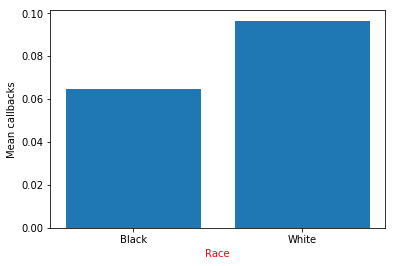

In [43]:
# Intial EDA shows us that there is a difference between the mean callbacks by race
# Plot a barchart of the callback means
race_groups = data.groupby("race")["call"].mean().reset_index()
race_groups["race"] = ["Black","White"]

plt.bar(race_groups["race"],race_groups["call"])
plt.xlabel("Race", color="red")
plt.ylabel("Mean callbacks")
plt.show()

In [44]:
# (3) Compute margin of error, confidence interval, and p-value. 
# Try using both the bootstrapping and the frequentist statistical approaches.

# 95% margin of error
moe = 1.96 * np.sqrt(np.var(data["call"])/4870)

# Functions to draw bootstrap replicates
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)
    return bs_replicates

# Compute the mean callbacks
mean_callbacks = np.mean(data["call"])

# Store callbacks by race
b_callbacks = b.call
w_callbacks = w.call

# Calculate the observed difference in means
observed_diff = np.mean(w_callbacks) - np.mean(b_callbacks)

# Computed the shifted callbacks assuming the mean is equal for both groups
b_callbacks_shifted = b_callbacks - np.mean(b.call) + mean_callbacks
w_callbacks_shifted = w_callbacks - np.mean(w.call) + mean_callbacks

# Draw 10,000 bootstrap replicates of the means
bs_reps_b = draw_bs_reps(b_callbacks_shifted, np.mean, 10000)
bs_reps_w = draw_bs_reps(w_callbacks_shifted, np.mean, 10000)

# Calculate the difference of means between replicates
bs_reps_diff = bs_reps_w - bs_reps_b

# Calculate the p value
p_bs = np.sum(bs_reps_diff >= observed_diff) / len(bs_reps_diff)
print(p_bs)

# Calculate the 95% confidence interval of the mean callbacks
ci_low = np.mean(data["call"]) - moe
ci_high = np.mean(data["call"]) + moe
print("The bootstrap 95% confidence interval for mean callbacks is " + str(ci_low) + " " + str(ci_high))

# Calculate the t statistic and p-value
stats.ttest_ind(w_callbacks, b_callbacks)

0.0
The bootstrap 95% confidence interval for mean callbacks is 0.07285194853599494 0.08813368519489342


Ttest_indResult(statistic=4.114705290861751, pvalue=3.940802103128886e-05)

In [45]:
# (4) Write a story describing the statistical significance in the context of the original problem.

# A very low p value for both the bootstrap test and the frequentist test tells us to reject the null hypothesis
# that the mean callback rates is equal for black and white-sounding names.
# The t-statistic of 4.11 tells us that the group means are approximately 4 times as different from each other
# than is the variablity within the same group.

# (5) Does your analysis mean that race/name is the most important factor in callback success? 
# Why or why not? If not, how would you amend your analysis?

# This analysis does not tell us about the importance of other factors when determining callbacks.
# We assume that other factors are considered in callback determination which are independent of race.
# In order to compare factors in callback determination, we would need to perform frequentist tests
# for each variable and compare the t-statistics.
